# Task 1 - Computing the BKM first four moments

## SPX

In [57]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# read data

data = pd.read_parquet('data/spx_ivs_2023-02.parquet')
data['date'] = pd.to_datetime(data['loctimestamp'], unit='ms').dt.date

In [59]:
# get risk free rate

rf_df = pd.read_csv('data/riskfree_30d_2023-02.csv', parse_dates=['date'])
rf_df['date'] = rf_df['date'].dt.date
rf_dict = rf_df.set_index('date')['yld_pct_annual'].to_dict()

In [ ]:
# price of volatility contract function for call
def V_C(K, S_t, P):
    return ((2 * (1 - np.log(K / S_t))) / K**2) * P

# price of volatility contract function for put
def V_P(K, S_t, P):
    return ((2 * (1 - np.log(S_t / K))) / K**2) * P

# price of volatility contract function
def V_integ(integrand_calls_v, Kc, integrand_puts_v, Kp):
    return np.trapz(integrand_calls_v, Kc) + np.trapz(integrand_puts_v, Kp)

# price of the cubic conctract for call
def W_C(K, S_t, P):
    return ((6 * np.log(K / S_t) - 3 * np.log(K / S_t)**2) / K**2) * P 

# price of the cubic conctract for put
def W_P(K, S_t, P):
    return -((6 * np.log(S_t / K) - 3 * np.log(S_t / K)**2) / K**2) * P

# price of the cubic contract
def W_integ(integrand_calls_w, Kc, integrand_puts_w, Kp):
    return np.trapz(integrand_calls_w, Kc) + np.trapz(integrand_puts_w, Kp)

# price of the quartic contract for call
def X_C(K, S_t, P):
    return ((12 * np.log(K / S_t)**2 - 4 * np.log(K / S_t)**3) / K**2) * P

# price of the quartic contract for put
def X_P(K, S_t, P):
    return ((12 * np.log(S_t / K)**2 - 4 * np.log(S_t / K)**3) / K**2) * P

# price of the quartic contract
def X_integ(integrand_calls_x, Kc, integrand_puts_x, Kp):
    return np.trapz(integrand_calls_x, Kc) + np.trapz(integrand_puts_x, Kp)

# mu
def mu(r, tau, V, W, X):
    return (np.exp(r * tau) - 1
            - (np.exp(r * tau) / 2) * V
            - (np.exp(r * tau) / 6) * W
            - (np.exp(r * tau) / 24) * X)

#skewness
def skew(r, tau, V, W, X, mu):
    numerator_skew = (np.exp(r * tau) * W
                      - 3 * mu * np.exp(r * tau) * V
                      + 2 * mu**3)
    denominator_skew = (np.exp(r * tau) * V - mu**2)**(3/2)
    return numerator_skew / denominator_skew

#kurtosis
def kurt(r, tau, V, W, X, mu):
    numerator_kurt = (np.exp(r * tau) * X
                      - 4 * mu * np.exp(r * tau) * W
                      + 6 * mu**2 * np.exp(r * tau) * V
                      - 3 * mu**4)
    denominator_kurt = (np.exp(r * tau) * V - mu**2)**2
    return numerator_kurt / denominator_kurt

In [ ]:
# compute the four moments
tau = 30 / 365 
results = []

for day in pd.date_range(start='2023-02-01', end='2023-02-28'):
    date = day.date()

    data_day = data[data['date'] == date]
    if data_day.empty:
        continue
    
    # get daily riskfree rate
    r = rf_dict.get(date, 3) / 100  # Falls kein Wert, Default 3%
    
    S_t = data_day['underlyingprice'].iloc[0]
    options = data_day[data_day['implPrice'].notnull()]
    
    integrand_calls_v = []
    integrand_puts_v = []
    integrand_calls_w = []
    integrand_puts_w = []
    integrand_calls_x = []
    integrand_puts_x = []
    
    Kc = []
    Kp = []

    for _, row in options.iterrows():
        K = row['strike']
        price = row['implPrice']
        if price <= 0:
            continue

        if row['putcall'] == 'C' and K >= S_t:

            integrand_calls_v.append(V_C(K, S_t, price))
            integrand_calls_w.append(W_C(K, S_t, price))
            integrand_calls_x.append(X_C(K, S_t, price))
            Kc.append(K)

        elif row['putcall'] == 'P' and K < S_t:

            integrand_puts_v.append(V_P(K, S_t, price))
            integrand_puts_w.append(W_P(K, S_t, price))
            integrand_puts_x.append(X_P(K, S_t, price))
            Kp.append(K)

    if len(Kc) < 2 or len(Kp) < 2:
        continue

    # numerical integration
    V = V_integ(integrand_calls_v, Kc, integrand_puts_v, Kp)

    W = W_integ(integrand_calls_w, Kc, integrand_puts_w, Kp)
    
    X = X_integ(integrand_calls_x, Kc, integrand_puts_x, Kp)
    
    # mu(t, tau)
    expected_mu = mu(r, tau, V, W, X)

    # SKEW(t, tau)
    expected_skew = skew(r, tau, V, W, X, expected_mu)

    # KURT(t, tau)
    expected_kurt = kurt(r, tau, V, W, X, expected_mu)

    results.append({
        'date': date,
        'underlying_price': S_t,
        'V': V,
        'W': W,
        'X': X,
        'mu': expected_mu,
        'skewness': expected_skew,
        'kurtosis': expected_kurt
    })

index_results_df = pd.DataFrame(results)

print(index_results_df)


          date  underlying_price         V         W         X        mu  \
0   2023-02-01           4138.45  0.002272 -0.000222  0.000095  0.002747   
1   2023-02-02           4163.94  0.002592 -0.000277  0.000127  0.002622   
2   2023-02-03           4132.64  0.002216 -0.000222  0.000093  0.002733   
3   2023-02-06           4108.81  0.002588 -0.000267  0.000122  0.002600   
4   2023-02-07           4161.15  0.002300 -0.000228  0.000101  0.002738   
5   2023-02-08           4122.03  0.002548 -0.000276  0.000125  0.002641   
6   2023-02-09           4082.54  0.002883 -0.000331  0.000157  0.002497   
7   2023-02-10           4087.64  0.002668 -0.000295  0.000138  0.002575   
8   2023-02-13           4135.26  0.003003 -0.000336  0.000167  0.002459   
9   2023-02-14           4144.65  0.002264 -0.000231  0.000099  0.002752   
10  2023-02-15           4138.02  0.002161 -0.000214  0.000089  0.002816   
11  2023-02-16           4097.89  0.002518 -0.000316  0.000138  0.002706   
12  2023-02-

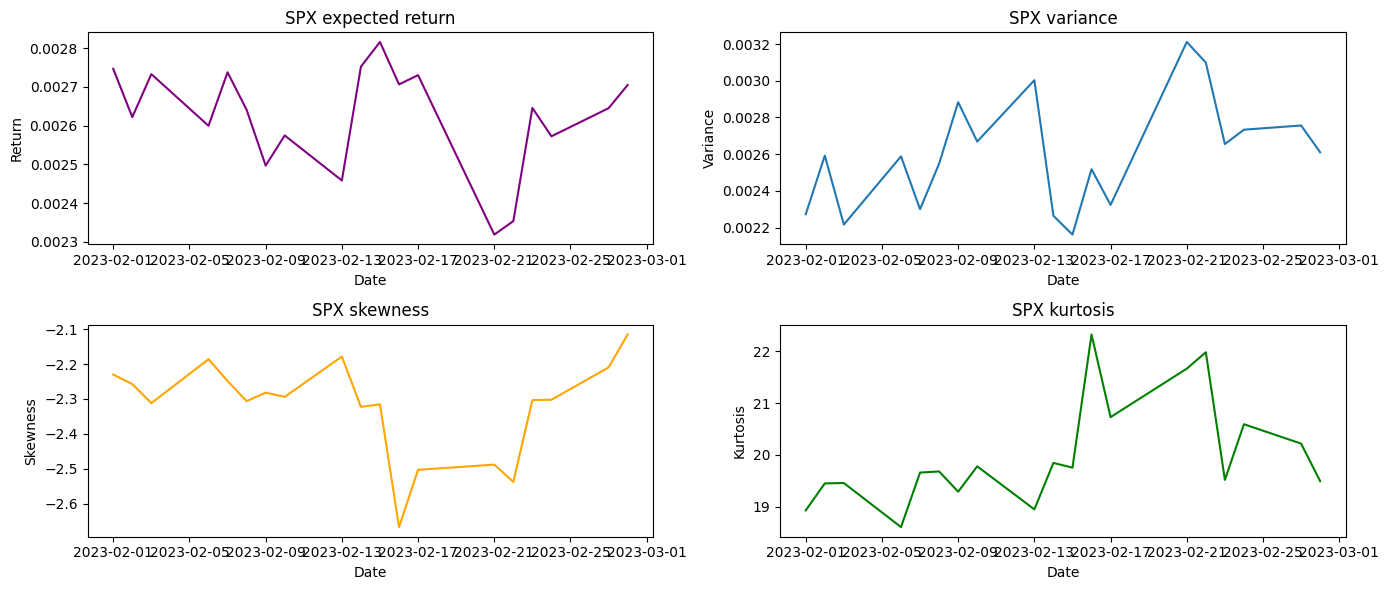

In [ ]:
# plot the first four moments
plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='mu', data=index_results_df, color='purple')
plt.title('SPX expected return')
plt.xlabel('Date')
plt.ylabel('Return')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='V', data=index_results_df)
plt.title('SPX variance')
plt.xlabel('Date')
plt.ylabel('Variance')

plt.subplot(2, 2, 3)
sns.lineplot(x='date', y='skewness', data=index_results_df, color='orange')
plt.title('SPX skewness')
plt.xlabel('Date')
plt.ylabel('Skewness')

plt.subplot(2, 2, 4)
sns.lineplot(x='date', y='kurtosis', data=index_results_df, color='green')
plt.title('SPX kurtosis')
plt.xlabel('Date')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()


## SP500 constituents

In [63]:
# read data
data = pd.read_parquet('data/sp500_merged_ivs_2023-02.parquet')
data['date'] = pd.to_datetime(data['loctimestamp'], unit='ms').dt.date

In [64]:
# get risk free rate
rf_df = pd.read_csv('data/riskfree_30d_2023-02.csv', parse_dates=['date'])
rf_df['date'] = rf_df['date'].dt.date
rf_dict = rf_df.set_index('date')['yld_pct_annual'].to_dict()

In [71]:
# compute the first moments
tau = 30 / 365
results = []

symbols = data['Symbol'].unique()

for symbol in symbols:
    data_symbol = data[data['Symbol'] == symbol]
    
    for day in pd.date_range(start='2023-02-01', end='2023-02-28'):
        date = day.date()

        data_day = data_symbol[data_symbol['date'] == date]
        if data_day.empty:
            continue

        # get daily riskfree rate
        r = rf_dict.get(date, 3) / 100
        
        S_t = data_day['underlyingprice'].iloc[0]
        options = data_day[data_day['implPrice'].notnull()]

        integrand_calls_v = []
        integrand_puts_v = []
        integrand_calls_w = []
        integrand_puts_w = []
        integrand_calls_x = []
        integrand_puts_x = []

        Kc = []
        Kp = []

        for _, row in options.iterrows():
            K = row['strike']
            price = row['implPrice']
            if price <= 0:
                continue

            if row['putcall'] == 'C' and K >= S_t:

                integrand_calls_v.append(V_C(K, S_t, price))
                integrand_calls_w.append(W_C(K, S_t, price))
                integrand_calls_x.append(X_C(K, S_t, price))
                Kc.append(K)

            elif row['putcall'] == 'P' and K < S_t:
                
                integrand_puts_v.append(V_P(K, S_t, price))
                integrand_puts_w.append(W_P(K, S_t, price))
                integrand_puts_x.append(X_P(K, S_t, price))
                Kp.append(K)

        if len(Kc) < 2 or len(Kp) < 2:
            continue
        
        # numerical integration
        V = V_integ(integrand_calls_v, Kc, integrand_puts_v, Kp)

        W = W_integ(integrand_calls_w, Kc, integrand_puts_w, Kp)
        
        X = X_integ(integrand_calls_x, Kc, integrand_puts_x, Kp)
        
        # mu(t, tau)
        expected_mu = mu(r, tau, V, W, X)

        # SKEW(t, tau)
        expected_skew = skew(r, tau, V, W, X, expected_mu)

        # KURT(t, tau)
        expected_kurt = kurt(r, tau, V, W, X, expected_mu)

        results.append({
            'symbol': symbol,
            'date': date,
            'underlying_price': S_t,
            'V': V,
            'W': W,
            'X': X,
            'mu': expected_mu,
            'skewness': expected_skew,
            'kurtosis': expected_kurt
        })

# Als DataFrame speichern oder ausgeben
results_df = pd.DataFrame(results)
print(results_df)


/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_36505/1957963885.py:48: RuntimeWarning: invalid value encountered in scalar power
  denominator_skew = (np.exp(r * tau) * V - mu**2)**(3/2)


     symbol        date  underlying_price         V         W         X  \
0         A  2023-02-01           155.960  0.006726 -0.000440  0.000402   
1         A  2023-02-02           154.995  0.007007 -0.000513  0.000411   
2         A  2023-02-03           153.980  0.006760 -0.000552  0.000414   
3         A  2023-02-06           151.880  0.007204 -0.000563  0.000447   
4         A  2023-02-07           154.285  0.007088 -0.000876  0.000548   
...     ...         ...               ...       ...       ...       ...   
9465    ZTS  2023-02-22           166.045  0.006349 -0.001225  0.000872   
9466    ZTS  2023-02-23           169.390  0.006402 -0.000783  0.000535   
9467    ZTS  2023-02-24           165.735  0.007540  0.000161  0.001077   
9468    ZTS  2023-02-27           165.330  0.010690  0.002913  0.002235   
9469    ZTS  2023-02-28           167.310  0.007919 -0.000946  0.001679   

            mu  skewness   kurtosis  
0     0.000535 -0.816370   8.863003  
1     0.000433 -0.88777

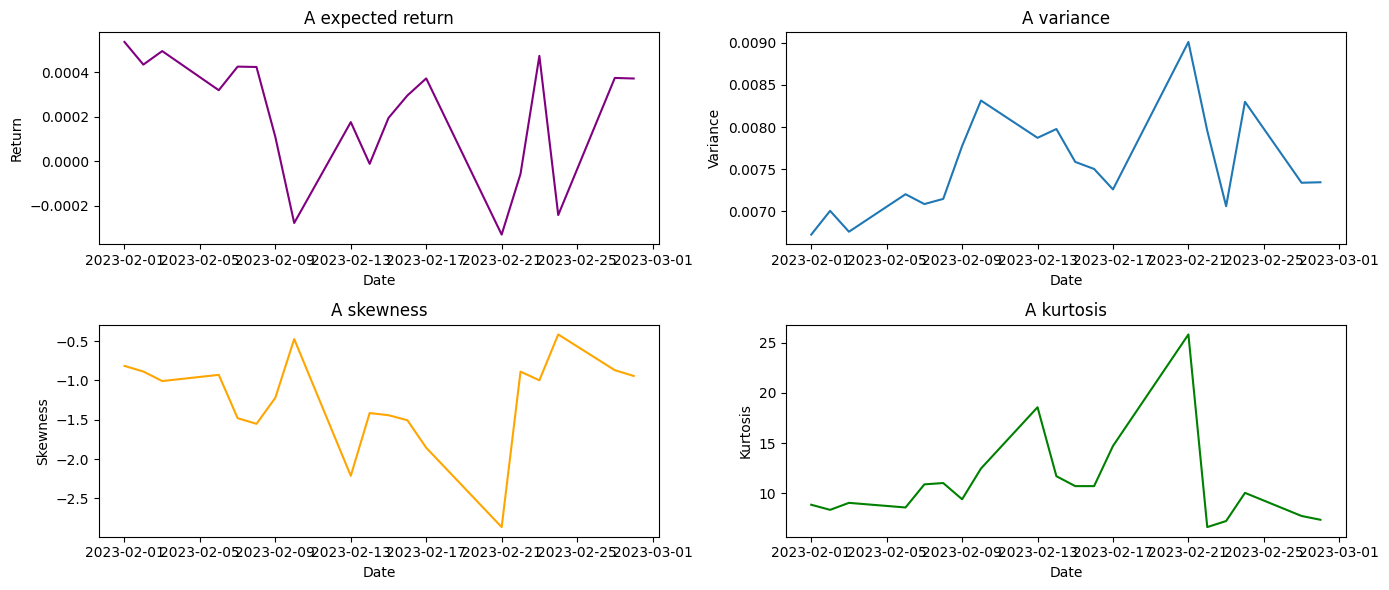

In [ ]:
# plot 'A' first four moments
a_data = results_df[results_df['symbol'] == 'A']

index_results_df['date'] = pd.to_datetime(index_results_df['date'])

plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='mu', data=a_data, color='purple')
plt.title('A expected return')
plt.xlabel('Date')
plt.ylabel('Return')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='V', data=a_data)
plt.title('A variance')
plt.xlabel('Date')
plt.ylabel('Variance')

plt.subplot(2, 2, 3)
sns.lineplot(x='date', y='skewness', data=a_data, color='orange')
plt.title('A skewness')
plt.xlabel('Date')
plt.ylabel('Skewness')

plt.subplot(2, 2, 4)
sns.lineplot(x='date', y='kurtosis', data=a_data, color='green')
plt.title('A kurtosis')
plt.xlabel('Date')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()


# Task 2 - Decomposing the BKM implied skewness into its systematic and idiosyncratic part

In [ ]:
# load beta data
beta_data = pd.read_parquet('data/sp500_merged_implBeta_2023-02.parquet')

# get market skewness
market_skew = results_df['skewness'].median()

for index, row in results_df.iterrows():
    symbol = row['symbol']
    beta = beta_data[beta_data['Symbol'] == symbol]['implBeta'].values[0]

    if np.isnan(beta):
        continue

    firm_skew = row['skewness']

    systematic = beta**3 * market_skew
    idiosyncratic = firm_skew - systematic

    results_df.at[index, 'systematic_skew'] = systematic
    results_df.at[index, 'idiosyncratic_skew'] = idiosyncratic 

print(results_df)
    


     symbol        date  underlying_price         V         W         X  \
0         A  2023-02-01           155.960  0.006726 -0.000440  0.000402   
1         A  2023-02-02           154.995  0.007007 -0.000513  0.000411   
2         A  2023-02-03           153.980  0.006760 -0.000552  0.000414   
3         A  2023-02-06           151.880  0.007204 -0.000563  0.000447   
4         A  2023-02-07           154.285  0.007088 -0.000876  0.000548   
...     ...         ...               ...       ...       ...       ...   
9465    ZTS  2023-02-22           166.045  0.006349 -0.001225  0.000872   
9466    ZTS  2023-02-23           169.390  0.006402 -0.000783  0.000535   
9467    ZTS  2023-02-24           165.735  0.007540  0.000161  0.001077   
9468    ZTS  2023-02-27           165.330  0.010690  0.002913  0.002235   
9469    ZTS  2023-02-28           167.310  0.007919 -0.000946  0.001679   

            mu  skewness   kurtosis  systematic_skew  idiosyncratic_skew  
0     0.000535 -0.816370

# Task 3 - Comparing Index and Individual Skewness

In [ ]:
# compare average values from Index to Individual Stocks

results = []


for symbol in symbols:
        data_symbol = results_df[results_df['symbol'] == symbol]
        
        firm_mu = data_symbol['mu'].mean()
        firm_var = data_symbol['V'].mean()
        firm_skew = data_symbol['skewness'].mean()
        firm_kurt = data_symbol['kurtosis'].mean()

        results.append({
                'symbol': symbol,
                'mu': firm_mu,
                'var': firm_var,
                'skew': firm_skew,
                'kurt': firm_kurt
        })

results.append({
        'symbol': 'SPX',
        'mu': index_results_df['mu'].mean(),
        'var': index_results_df['V'].mean(),
        'skew': index_results_df['skewness'].mean(),
        'kurt': index_results_df['kurtosis'].mean()
})


comparison_df = pd.DataFrame(results)

print(comparison_df)

    symbol        mu       var      skew       kurt
0        A  0.000214  0.007539 -1.252234  11.049528
1      AAL -0.002004  0.012065 -0.986210  10.774808
2      AAP -0.002644  0.013578 -1.252429   8.750593
3     AAPL  0.000661  0.006598 -1.292050  13.066584
4     ABBV  0.002038  0.003768 -1.468074  13.344565
..     ...       ...       ...       ...        ...
496    ZBH  0.001914  0.004115 -1.811922  15.982742
497   ZBRA -0.002315  0.012668 -0.749018   8.555358
498   ZION  0.000510  0.006879 -1.013597   8.177951
499    ZTS  0.000309  0.007317 -1.427215  16.136099
500    SPX  0.002624  0.002600 -2.319006  19.995911

[501 rows x 5 columns]


In [72]:
# share of individual skew below index skew
count = 0

spx_skew = comparison_df.loc[comparison_df['symbol'] == 'SPX', 'skew'].iloc[0]

for index, row in comparison_df.iterrows():
    symbol = row['symbol']
    if symbol == 'SPX':
        continue

    if row['skew'] < spx_skew:
        count += 1

share = count / 500

print(share)


0.038
